## Importing Libraries

In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import time

## Part 1: Solving Initial Problem

### Solving Main and Dual Problem

For Newton method with equality constraints we have:
$$
\begin{bmatrix}
\nabla^2 f(x_t) & A^T\\
A & 0
\end{bmatrix}
\begin{bmatrix}
v^*\\
\mu^*
\end{bmatrix}
=
\begin{bmatrix}
-\nabla f(x_t)\\
0
\end{bmatrix}
$$

And also we can find the value of step size ($t$) with backtracking line search. For this problem we know
$$
\dfrac{\partial f}{\partial x_i}(x) = c_i - \dfrac{1}{x_i}
$$
Also we know
$$
\dfrac{\partial^2 f}{\partial x_i \partial x_j}(x) = 
\begin{cases}
0 \quad i \ne j\\
\dfrac{1}{x_i^2} \quad i=j
\end{cases}
$$

For dual problem we know that $\mu^*$ is its answer.

### Functions For Solving Problem

In [7]:
np.seterr(all="warn")

def f(c, x):
  return np.transpose(c)@x - np.sum(np.log(x))

def backtracking_line_search(c, x, v, alpha, beta):
  t = 1
  y = f(c, x)
  z = alpha*np.transpose(c-1/x)@v
  while False in (x+t*v > 0):
    t = beta*t
  while f(c, x+t*v) > y + t*z:
    t = beta*t
  return x+t*v

def newton_solver(A, b, c, x0, alpha=0.25, beta=0.5):
  m, n = A.shape
  lambdas = []
  cnt = 1 # number of steps
  kkt_matrix = np.zeros((n+m, n+m))
  np.fill_diagonal(kkt_matrix, np.vstack((1/x0**2, np.zeros((m, 1)))))
  kkt_matrix[n:, :n] = A.copy()
  kkt_matrix[:n, n:] = np.transpose(A.copy())
  v = np.linalg.inv(kkt_matrix)[:n]@np.vstack((-c+1/x0, np.zeros((m, 1)))) # newton's direction
  dual_ans = np.linalg.inv(kkt_matrix)[n:]@np.vstack((-c+1/x0, np.zeros((m, 1)))) # answer of the dual problem
  x = backtracking_line_search(c, x0, v, alpha, beta)
  hessian = np.zeros((n, n))
  np.fill_diagonal(hessian, 1/x**2)
  lambda_ = np.transpose(v)@hessian@v
  lambdas.append(lambda_/2)
  while lambda_/2 > 1e-6:
    kkt_matrix = np.zeros((n+m, n+m))
    np.fill_diagonal(kkt_matrix, np.vstack((1/x**2, np.zeros((m, 1)))))
    kkt_matrix[n:, :n] = A.copy()
    kkt_matrix[:n, n:] = np.transpose(A.copy())
    v = np.linalg.inv(kkt_matrix)[:n]@np.vstack((-c+1/x, np.zeros((m, 1)))) # newton's direction
    dual_ans = np.linalg.inv(kkt_matrix)[n:]@np.vstack((-c+1/x, np.zeros((m, 1)))) # answer of the dual problem
    x = backtracking_line_search(c, x, v, alpha, beta)
    hessian = np.zeros((n, n))
    np.fill_diagonal(hessian, 1/x**2)
    lambda_ = np.transpose(v)@hessian@v
    lambdas.append(lambda_/2)
    cnt += 1
  return cnt, x, dual_ans, np.array(lambdas).flatten()

# testing solver
m, n = 5, 8
A = np.random.randn(m-1, n)
B = np.random.random((1, n))
A = np.vstack((A, B))
x0 = np.random.random((n, 1))
b = A@x0
c = np.random.randn(n, 1)

cnt, x, y, lambdas = newton_solver(A, b, c, x0)
print(f"Number of iterations is: {cnt}")
print("Optimal point for main problem is: ", end='')
for it in list(x.flatten()):
  print("{:.5f}".format(it), end=' ')
print()
print("Optimal point for dual problem is: ", end='')
for it in list(y.flatten()):
  print("{:.5f}".format(it), end=' ')
print()

Number of iterations is: 6
Optimal point for main problem is: 0.59556 1.62604 0.21657 0.71153 0.51391 0.95649 0.76450 0.18567 
Optimal point for dual problem is: 0.64971 1.09639 0.75440 0.21142 2.74783 


### Plot of Error vs Number of Steps

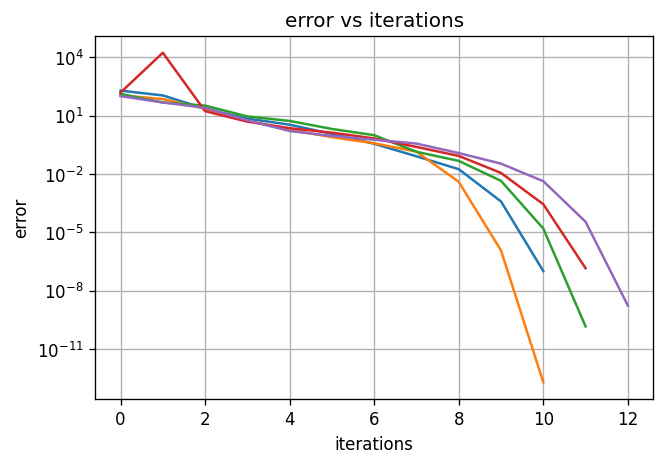

In [9]:
m, n = 200, 500
plt.figure(dpi=120)
for i in range(5):
  A = np.random.randn(m-1, n)
  B = np.random.random((1, n))
  A = np.vstack((A, B))
  x0 = np.random.random((n, 1))
  b = A@x0
  c = np.random.randn(n, 1)
  cnt, x, y, lambdas = newton_solver(A, b, c, x0)
  plt.semilogy(lambdas)
plt.xlabel('iterations')
plt.ylabel('error')
plt.title('error vs iterations')
plt.grid()

### Effect of $\alpha$

As you can see in the following figure if we increase $\alpha$ then number of iterations will be increase. 

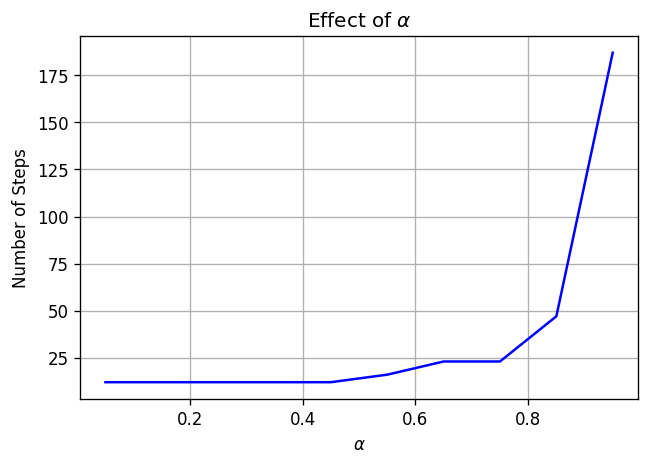

In [10]:
m, n = 200, 500
A = np.random.randn(m-1, n)
B = np.random.random((1, n))
A = np.vstack((A, B))
x0 = np.random.random((n, 1))
b = A@x0
c = np.random.randn(n, 1)
alphas = np.linspace(0.05, 0.95, 10)
cnts = []

for alpha in list(alphas):
  cnt, _, _, _ = newton_solver(A, b, c, x0, alpha=alpha)
  cnts.append(cnt)

plt.figure(dpi=120)
plt.plot(alphas, cnts, color='blue')
plt.title('Effect of $\\alpha$')
plt.xlabel('$\\alpha$')
plt.ylabel('Number of Steps')
plt.grid()

### Effect of $\beta$

As you can see in the following figure if we increase $\beta$ then number of iterations will be decrease. 

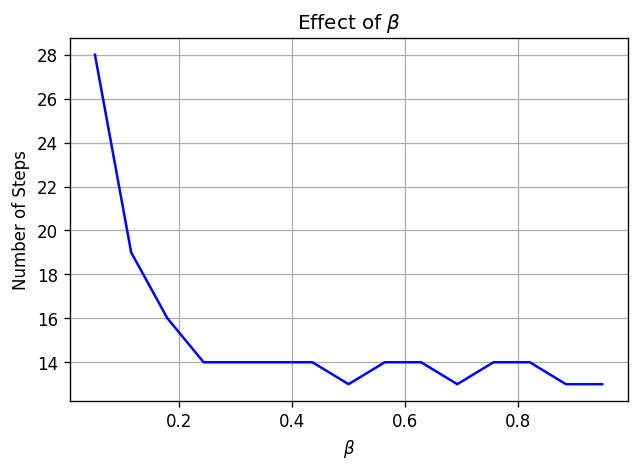

In [11]:
m, n = 200, 500
A = np.random.randn(m-1, n)
B = np.random.random((1, n))
A = np.vstack((A, B))
x0 = np.random.random((n, 1))
b = A@x0
c = np.random.randn(n, 1)
betas = np.linspace(0.05, 0.95, 15)
cnts = []

for beta in list(betas):
  cnt, _, _, _ = newton_solver(A, b, c, x0, beta=beta)
  cnts.append(cnt)

plt.figure(dpi=120)
plt.plot(betas, cnts, color='blue')
plt.title('Effect of $\\beta$')
plt.xlabel('$\\beta$')
plt.ylabel('Number of Steps')
plt.grid()

### Checking KKT

For this problem KKT is as below

$$
\begin{cases}
c_i - \dfrac{1}{x^*_i} + (A^T \nu^*)_i = 0\\
Ax^* = b
\end{cases}
$$ 

In [12]:
m, n = 5, 8
A = np.random.randn(m-1, n)
B = np.random.random((1, n))
A = np.vstack((A, B))
x0 = np.random.random((n, 1))
b = A@x0
c = np.random.randn(n, 1)

_, x, y, _ = newton_solver(A, b, c, x0)
print("Norm of c-1/x+AT*v is {:.3e}".format(np.sqrt(np.sum((c-1/x+A.T@y)**2))))
print("Norm of A*x-b is {:.3e}".format(np.sqrt(np.sum((A@x-b)**2))))

Norm of c-1/x+AT*v is 2.369e-09
Norm of A*x-b is 1.246e-15


## Part 2: Barrier Method

### Function For Barrier Method

In [13]:
def barrier_method(A, b, c, x0, alpha=0.25, beta=0.5, mu=10):
  t = 1
  history = []
  m, n = A.shape
  cnt, x, _, _ = newton_solver(A, b, t*c, x0, alpha, beta)
  duality_gap = m/t
  history.append([cnt, duality_gap])
  while duality_gap >= 1e-3:
    t = mu*t
    cnt, x, _, _ = newton_solver(A, b, t*c, x, alpha, beta)
    duality_gap = m/t
    history.append([cnt, duality_gap])
  return x, np.array(history).T

### Duality Gap vs Number of Steps

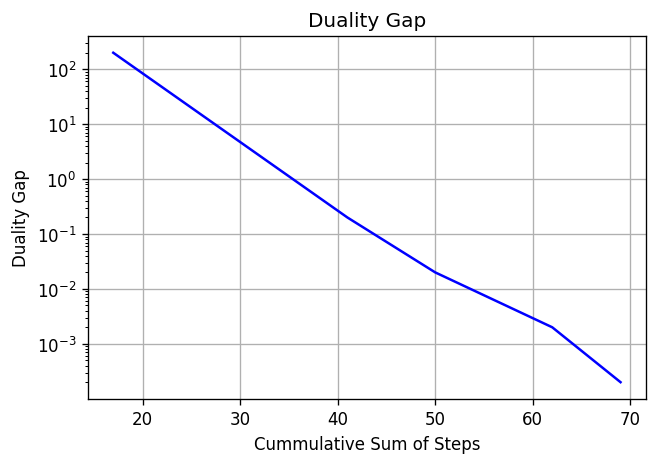

In [14]:
m, n = 200, 500
A = np.random.randn(m-1, n)
B = np.random.random((1, n))
A = np.vstack((A, B))
x0 = np.random.random((n, 1))
b = A@x0
c = np.random.randn(n, 1)

t0 = time.time()
x, history = barrier_method(A, b, c, x0)
our_delta_t = time.time() - t0

plt.figure(dpi=120)
plt.semilogy(np.cumsum(history[0,:]), history[1,:], color='blue')
plt.title('Duality Gap')
plt.ylabel('Duality Gap')
plt.xlabel('Cummulative Sum of Steps')
plt.grid()

### Check Results With CVXPY

In [15]:
y = cp.Variable(n)
constraints = [A@y==b[:,0], y>=0]
cost = c.T@y
prob = cp.Problem(cp.Minimize(cost), constraints)
t0 = time.time()
prob.solve()
cvx_delta_t = time.time() - t0
print('Square error between our result and CVX\'s result for vectors is: {:.5f}'.format(np.sqrt(np.sum((y.value-x.flatten())**2))))
print('Square error between our result and CVX\'s result for minimum cost is: {:.5f}'.format(np.sqrt((cost.value-c.T@x)**2)[0,0]))
print('CVX is faster than our program. Difference between times is about {:.3f}s'.format(our_delta_t-cvx_delta_t))

Square error between our result and CVX's result for vectors is: 0.00192
Square error between our result and CVX's result for minimum cost is: 0.00030
CVX is faster than our program. Difference between times is about 11.155s


### Effect of $μ$

As you can see in the following figure if we increase $\mu$ then number of iterations and total time of calculation will be decrease. 

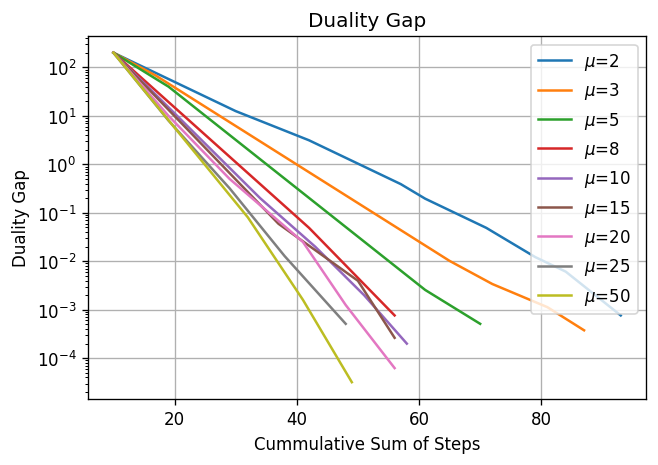

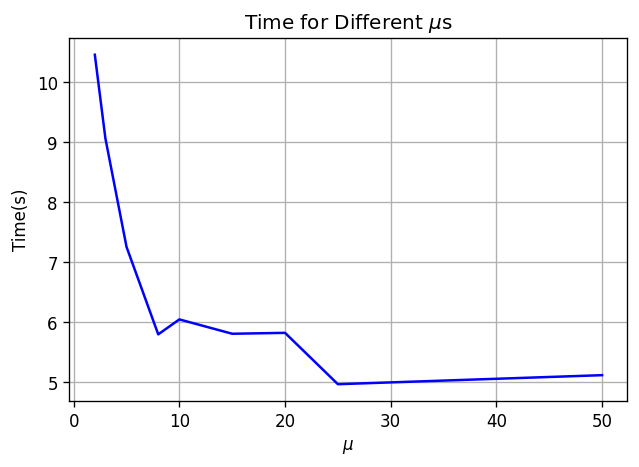

In [16]:
mus = [2, 3, 5, 8, 10, 15, 20, 25, 50]
m, n = 200, 500
A = np.random.randn(m-1, n)
B = np.random.random((1, n))
A = np.vstack((A, B))
x0 = np.random.random((n, 1))
b = A@x0
c = np.random.randn(n, 1)
times = []

plt.figure(dpi=120)
for mu in mus:
  t0 = time.time()
  x, history = barrier_method(A, b, c, x0, mu=mu)
  times.append(time.time()-t0)
  plt.semilogy(np.cumsum(history[0,:]), history[1,:], label=f'$\mu$={mu}')
plt.title('Duality Gap')
plt.ylabel('Duality Gap')
plt.xlabel('Cummulative Sum of Steps')
plt.grid()
plt.legend()
plt.show()


plt.figure(dpi=120)
plt.plot(mus, times, color='blue')
plt.title('Time for Different $\mu$s')
plt.xlabel('$\mu$')
plt.ylabel('Time(s)')
plt.grid()
plt.show()

## Part 3: Completing LP Solver

### LP Solver

If we define $z=x+(t-1)\textbf{1}$ then we have $z \succeq 0$ and also $t \ge 0$. So we can define $y=(z, t)$ which is a positive vector.
$$
z=x+(t-1)\textbf{1}\\
Az = Ax + (t-1) A\textbf{1}\\
Az - A\textbf{1}t = b - A\textbf{1}\\
\begin{bmatrix}
A & -A\textbf{1}
\end{bmatrix}
\begin{bmatrix}
z\\
t
\end{bmatrix}
= b - A\textbf{1}
$$
From above equations it's obvious that we can write $A'y=b'$ where $A'=\begin{bmatrix}
A & -A\textbf{1}
\end{bmatrix}$
and $b'=b - A\textbf{1}$. Now we can use previous part to solve this optimization problem.

In [17]:
def feasible_point(A, b, alpha=0.25, beta=0.5, mu=10):
  # find a nonsingular submatrix of A for find x0
  m, n = A.shape
  A1 = np.hstack((A, -A@np.ones((n, 1))))
  b1 = b-A@np.ones((n, 1))
  c1 = np.zeros((n+1, 1))
  c1[-1] = 1
  y0 = np.zeros((n+1, 1))
  x0 = np.zeros((n, 1))
  B = A[:m, :m]
  for i in range(n):
    solved = False
    for j in range(n):
      if np.linalg.det(A[i:i+m, j:j+m]) != 0:
        B = A[i:i+m, j:j+m]
        x0[i:i+m] = np.linalg.inv(B)@b
        solved = True
        break
    if solved:
      break
  if False not in (x0 > 0):
    return x0, True
  t0 = 2 - np.min(x0)
  y0 = np.vstack((x0+(t0-1)*np.ones((n, 1)), t0))
  y, _ = barrier_method(A1, b1, c1, y0, alpha, beta, mu)
  t = y[-1]
  if t < 1:
    x = y[:n] - (t-1)*np.ones((n, 1))
    return x, True
  return None, False

def LP_solver(A, b, c, alpha=0.25, beta=0.5, mu=5):
  if len(A.shape) != 2:
    raise Exception("\'A\' must be a 2 dimensional array.")
  m, n = A.shape
  if m >= n:
    raise Exception("Number of equalities should be less than variables in Ax=b")
  x, is_sc = feasible_point(A, b, alpha, beta, mu)
  if not is_sc:
    print("Problem is infeasible.")
    return None
  return barrier_method(A, b, c, x, alpha, beta, mu)[0]

### Testing For Feasible Problems

In [18]:
# define a random and feasible problem
m, n = 200, 500
A = np.random.randn(m-1, n)
B = np.random.random((1, n))
A = np.vstack((A, B))
x0 = np.random.random((n, 1))
b = A@x0
c = np.random.randn(n, 1)

# our LP Solver
t0 = time.time()
x = LP_solver(A, b, c)
our_time = time.time() - t0

# CVX solver
y = cp.Variable(n)
constraints = [A@y==b[:,0], y>=0]
cost = c.T@y
prob = cp.Problem(cp.Minimize(cost), constraints)
t0 = time.time()
prob.solve()
cvx_time = time.time() - t0

print('Square error between our result and CVX\'s result for vectors is: {:.3e}'.format(np.sqrt(np.sum((y.value-x.flatten())**2))))
print('Square error between our result and CVX\'s result for minimum cost is: {:.3e}'.format(np.sqrt((cost.value-c.T@x)**2)[0,0]))
print('CVX is faster than our program. Difference between times is about {:.3f}s'.format(our_time-cvx_time))

Square error between our result and CVX's result for vectors is: 8.269e-03
Square error between our result and CVX's result for minimum cost is: 7.680e-04
CVX is faster than our program. Difference between times is about 13.527s


### Testing For Infeasible Point

In [19]:
# define a random and infeasible problem
m, n = 200, 500
A = np.random.random((m-1, n))
B = np.random.random((1, n))
A = np.vstack((A, B))
b = np.random.randn(m, 1)
c = np.random.randn(n, 1)

# our LP Solver
x = LP_solver(A, b, c)
print(x)

Problem is infeasible.
None


In [20]:
# CVX solver
y = cp.Variable(n)
constraints = [A@y==b[:,0], y>=0]
cost = c.T@y
prob = cp.Problem(cp.Minimize(cost), constraints)
prob.solve()
print(y.value)

None
